# R(Q) calculation example for simulated SLD profile

Take a simulated SLD profile in constant depth increment and compute R(Q).

Note: In the example below, the substrate needs to be added. If this is meant to be compare to a real measurement, one can also adjust the roughness on the substrate and/or add an oxide layer.

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import json
import refl1d
from refl1d.names import *

In [9]:
data_path = os.path.join(os.path.expanduser('~'), 'git/refl1d_analysis/test/data')
data_file = os.path.join(data_path, 'SLD_t0.txt')
sld_data = np.loadtxt(data_file, skiprows=0, delimiter=' ').T

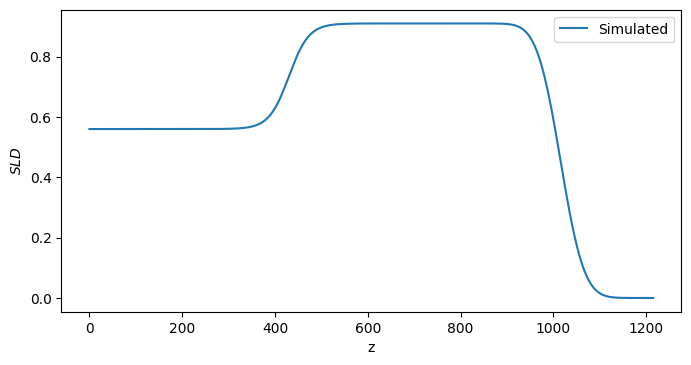

In [13]:
fig = plt.figure(dpi=100, figsize=[8,4])

plt.plot(sld_data[0], sld_data[1], label='Simulated')

plt.xlabel('z')
plt.ylabel('$SLD$')
plt.legend()

In [16]:
 def calculate_reflectivity(q, z_step, sld, q_resolution=0.025, get_SLD=False):
    """
        Reflectivity calculation using refl1d
        Set get_SLD to True to get the final SLD profile, which includes the substrate.
    """
    zeros = np.zeros(len(q))
    dq = q_resolution * q

    # The QProbe object represents the beam
    probe = QProbe(q, dq, data=(zeros, zeros))

    sample = Slab(material=SLD(name='back', rho=2.07), interface=2)
    
    # Add each layer
    for i, _sld in enumerate(sld):
        sample = sample | Slab(material=SLD(name='l_%d' % i, rho=_sld, irho=0),
                                            thickness=z_step,
                                            interface=0)

    sample = sample | Slab(material=SLD(name='front', rho=0))

    probe.background = Parameter(value=0, name='background')
    expt = Experiment(probe=probe, sample=sample)

    q, r = expt.reflectivity()
    
    if get_SLD:
        z, sld, _ = expt.smooth_profile()
        return z, sld

    return r

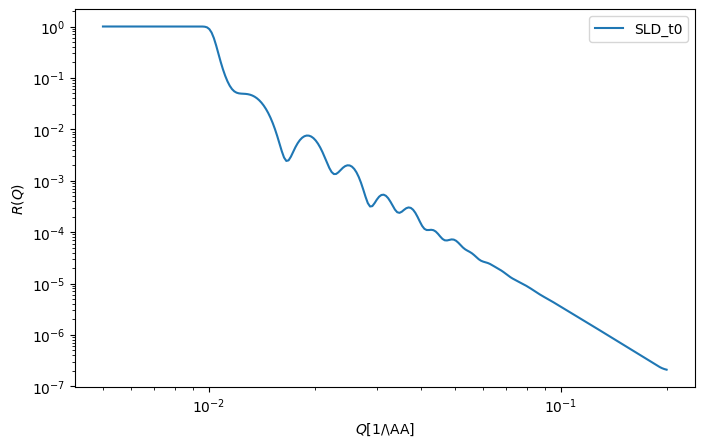

In [23]:
# Define output Q range
q = np.logspace(np.log10(0.005), np.log10(0.2), num=250)

# Get the z-step
z_step = sld_data[0][1]-sld_data[0][0]

# Compute and save the reflectivity
_r = calculate_reflectivity(q, z_step, sld_data[1])
np.savetxt(os.path.join(data_path, 'R_t0.txt'), np.asarray([q, _r]).T)


fig = plt.figure(dpi=100, figsize=[8,5])
plt.plot(q, _r, label='SLD_t0')
plt.xlabel('$Q [1/$\AA$]$')
plt.ylabel('$R(Q)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()

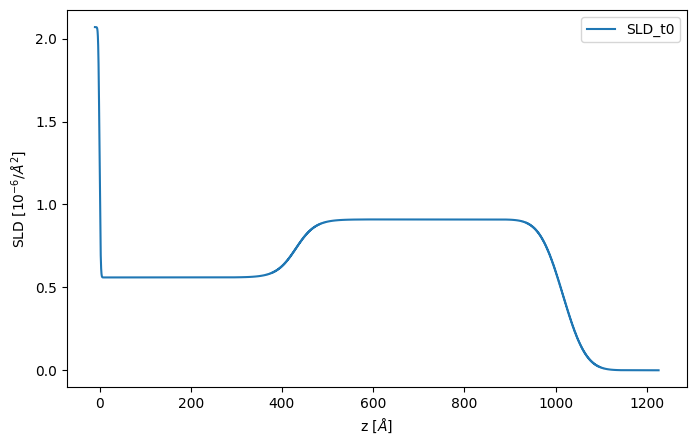

In [22]:
_z, _sld = calculate_reflectivity(q, z_step, sld_data[1], get_SLD=True)

fig = plt.figure(dpi=100, figsize=[8,5])
plt.plot(_z, _sld, label='SLD_t0')
plt.xlabel('z [$\AA$]')
plt.ylabel('SLD [$10^{-6}/\AA^2$]')
plt.legend()